In [1]:
# 텐서플로우 GPU 연결
# import os
# import tensorflow as tf 
# from tensorflow.python.client import device_lib
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# import tensorflow as tf 
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices() )

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from defDef import *
import seaborn as sns
import scipy.stats as stats
from scipy.stats import linregress
import statsmodels.api as sm
import warnings

import tensorflow as tf
from tensorflow import keras as tf_keras

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# print 옵션
# pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.width', None)  # 열(칼럼) 생략없이
# pd.set_option('display.max_row', None)  # 행 생략없이
warnings.filterwarnings("ignore")


In [3]:
# ----------------------------------------------------------------------------
# 데이터
# ----------------------------------------------------------------------------
ks = og_DefColl.preprocess_df(pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\kospi200\\일 ks200 90.01.13~24.01.19.csv'))

ks['change'] = (ks['c'] - ks['o']) / ks['o'] * 100
ks['range'] = ks['h'] - ks['l']
ks['body'] = (ks['c'] - ks['o']).abs()

ks = og_Calculator.atr(ks, period=14)
ks = og_Calculator.atr_bands(ks, period=14, d=0.5)

# y labeling
ks['y'] = 0

# og
ks = og_Calculator.labeling(ks, case=0, v=None)
ks['y'] = ks['y'].shift(-1)

# body
ks.loc[ks['body'].shift(-1) >= ks['body'], 'y'] = 1

ks = ks[['datetime', 'change', 'range', 'body', 'v', 'y']]
ks

,datetime,change,range,body,v,y
0,1990-01-03,NaN,NaN,NaN,4025.0,0
1,1990-01-04,NaN,NaN,NaN,10005.0,0
2,1990-01-05,NaN,NaN,NaN,10658.0,0
3,1990-01-08,NaN,NaN,NaN,7806.0,0
4,1990-01-09,NaN,NaN,NaN,8242.0,0
...,...,...,...,...,...,...
8378,2024-01-15,0.186055,2.88,0.63,86541.0,1
8379,2024-01-16,-0.897087,4.52,3.03,94324.0,1
8380,2024-01-17,-2.801705,10.00,9.40,134916.0,0
8381,2024-01-18,0.076481,3.68,0.25,98179.0,1


In [4]:
sentiment = pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\created_csv\\sentiment.csv')
sentiment['datetime'] = pd.to_datetime(sentiment['datetime'])
sentiment = sentiment[['datetime', 'sentiment']]
sentiment

,datetime,sentiment
0,2007-04-16,115.500000
1,2007-04-17,126.500000
2,2007-04-18,145.000000
3,2007-04-19,146.500000
4,2007-04-20,124.500000
...,...,...
4108,2023-08-10,16.666667
4109,2023-08-11,14.500000
4110,2023-08-14,15.000000
4111,2023-08-15,23.333333


In [5]:
options_o = pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\kospi200\\options\\ks200_options_o.csv')
options_h = pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\kospi200\\options\\ks200_options_h.csv')
options_l = pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\kospi200\\options\\ks200_options_l.csv')
options_c = pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\kospi200\\options\\ks200_options_c.csv')
options_v = pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\kospi200\\options\\ks200_options_v.csv')

options_o, options_h, options_l, options_c, options_v = DefColl.sync_dfs_lst([options_o, options_h, options_l, options_c, options_v])

call_options = pd.DataFrame({
    'datetime':options_o['datetime'],
    'o':options_o['call'],
    'h':options_h['call'],
    'l':options_l['call'],
    'c':options_c['call'],
    'change':np.log(options_c['call']).diff(1),
    'range':options_h['call'] - options_l['call'],
    'body':(options_c['call'] - options_o['call']).abs()
})
put_options = pd.DataFrame({
    'datetime':options_o['datetime'],
    'o':options_o['put'],
    'h':options_h['put'],
    'l':options_l['put'],
    'c':options_c['put'],
    'change':np.log(options_c['put']).diff(1),
    'range':options_h['put'] - options_l['put'],
    'body':(options_c['put'] - options_o['put']).abs()
})
options = pd.DataFrame({
    'datetime':call_options['datetime'],
    'call_c':call_options['c'],
    'put_c':put_options['c'],
    'premium_sum':call_options['c'] + put_options['c'],
    'premium_diff':call_options['c'] - put_options['c'],
    'callput_ratio':options_v['call'] / options_v['put'],
    'call_change':call_options['change'],
    'call_range':call_options['range'],
    'call_body':call_options['body'],
    'put_change':put_options['change'],
    'put_range':put_options['range'],
    'put_body':put_options['body'],
})

# 이상치 제거
options = options[options['datetime'].dt.year >= 1999]
options

,datetime,call_c,put_c,premium_sum,premium_diff,callput_ratio,call_change,call_range,call_body,put_change,put_range,put_body
363,1999-01-04,5.50,1.11,6.61,4.39,0.401081,0.293761,1.85,0.75,-0.811931,1.31,1.09
364,1999-01-05,6.40,0.98,7.38,5.42,0.647816,0.151550,1.20,0.50,-0.124563,0.30,0.17
365,1999-01-06,6.95,0.55,7.50,6.40,0.414606,0.082444,0.75,0.55,-0.577634,0.56,0.35
366,1999-01-07,10.90,0.18,11.08,10.72,0.579686,0.450021,3.60,3.45,-1.116961,0.31,0.22
367,1999-01-08,9.30,0.19,9.49,9.11,0.636634,-0.158748,2.05,0.70,0.054067,0.32,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...
6538,2024-01-05,5.72,1.57,7.29,4.15,1.490398,-0.238411,1.80,0.97,0.019293,0.75,0.08
6539,2024-01-08,4.22,1.42,5.64,2.80,1.393188,-0.304134,3.46,2.91,-0.100419,0.94,0.42
6540,2024-01-09,2.89,1.24,4.13,1.65,1.445467,-0.378579,6.18,4.18,-0.135545,1.47,0.97
6541,2024-01-10,0.67,2.41,3.08,-1.74,1.145500,-1.461734,2.65,1.41,0.664515,2.17,0.96


In [6]:
es = og_DefColl.preprocess_df(pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\index\\일 S&P 500 79.12.26~.csv'))
es['change'] = (es['c'].diff() / es['c'].shift() * 100)
es['range'] = es['h'] - es['l']
es['body'] = (es['c'] - es['o']).abs()

es['ma1'] = es['c'].rolling(5).mean()
es['ma_up1'] = 0
es.loc[es['c'] > es['ma1'], 'ma_up1'] = 1

es['ma2'] = es['c'].rolling(21).mean()
es['ma_up2'] = 0
es.loc[es['c'] > es['ma2'], 'ma_up2'] = 1

es['ma3'] = es['c'].rolling(252).mean()
es['ma_up3'] = 0
es.loc[es['c'] > es['ma3'], 'ma_up3'] = 1

es['daily_var'] = (es['change']**2).rolling(5).sum()
es['weekly_var'] = es['change'].rolling(5).sum()**2
es['var_diff'] = es['daily_var'] - es['weekly_var']


es = es[['datetime', 'change', 'v']]
es

,datetime,change,v
0,1980-01-02,NaN,4.061000e+07
1,1980-01-03,-0.510591,5.048000e+07
2,1980-01-04,1.235503,3.913000e+07
3,1980-01-07,0.272250,4.450000e+07
4,1980-01-08,2.003557,5.339000e+07
...,...,...,...
11135,2024-03-04,-0.119326,2.818870e+09
11136,2024-03-05,-1.019310,2.704129e+09
11137,2024-03-06,0.514110,4.559050e+09
11138,2024-03-07,1.030413,2.359269e+09


In [7]:
ksvx = og_DefColl.preprocess_df(pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\volatility\\일 ksvx 03.01.02~24.01.19.csv'))

ksvx['ma1'] = ksvx['c'].rolling(5).mean()
ksvx['ma_up1'] = 0
ksvx.loc[ksvx['c'] > ksvx['ma1'], 'ma_up1'] = 1

ksvx['ma2'] = ksvx['c'].rolling(21).mean()
ksvx['ma_up2'] = 0
ksvx.loc[ksvx['c'] > ksvx['ma2'], 'ma_up2'] = 1

ksvx['ma3'] = ksvx['c'].rolling(252).mean()
ksvx['ma_up3'] = 0
ksvx.loc[ksvx['c'] > ksvx['ma3'], 'ma_up3'] = 1

ksvx = ksvx[['datetime', 'c']]
ksvx

,datetime,c
0,2003-01-02,35.57
1,2003-01-03,34.50
2,2003-01-06,33.04
3,2003-01-07,33.98
4,2003-01-08,33.17
...,...,...
5201,2024-01-15,16.84
5202,2024-01-16,17.18
5203,2024-01-17,19.31
5204,2024-01-18,18.32


In [8]:
vx = og_DefColl.preprocess_df(pd.read_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\kospi200\\일 vx 90.01.03~.csv'))

vx['ma1'] = vx['c'].rolling(5).mean()
vx['ma_up1'] = 0
vx.loc[vx['c'] > vx['ma1'], 'ma_up1'] = 1

vx['ma2'] = vx['c'].rolling(21).mean()
vx['ma_up2'] = 0
vx.loc[vx['c'] > vx['ma2'], 'ma_up2'] = 1

vx['ma3'] = vx['c'].rolling(252).mean()
vx['ma_up3'] = 0
vx.loc[vx['c'] > vx['ma3'], 'ma_up3'] = 1

vx = vx[['datetime', 'c']]
vx

,datetime,c
0,1990-01-02,17.240000
1,1990-01-03,18.190001
2,1990-01-04,19.219999
3,1990-01-05,20.110001
4,1990-01-08,20.260000
...,...,...
8607,2024-03-04,13.490000
8608,2024-03-05,14.460000
8609,2024-03-06,14.500000
8610,2024-03-07,14.440000


In [10]:
# # 분포 확인
# selected_col = [col for col in ks.columns if col not in ['datetime', 'y']]
# fig, axes = plt.subplots(3, 6, figsize=(14, 4))
# for idx, ax in enumerate(axes.flatten()):
#     if idx == len(ks[selected_col].columns):
#         break
#     ax.hist(ks.values[:, idx], bins=100)
# plt.show()
# print(ks.values[:, idx])

In [11]:
df = ks
df = pd.merge(df, es, how='inner', on='datetime')
df = pd.merge(df, vx, how='inner', on='datetime')
df = pd.merge(df, ksvx, how='inner', on='datetime')
df = pd.merge(df, sentiment, how='inner', on='datetime')
df = pd.merge(df, options, how='inner', on='datetime')

In [13]:
# drop
df = df[[col for col in df.columns if col[-2:] != '_y']]

# nan값 제거
# 무한대 값을 NaN으로 대체
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 값을 포함하는 행 제거
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,datetime,change_x,range,body,v_x,y,c_x,sentiment,call_c,put_c,premium_sum,premium_diff,callput_ratio,call_change,call_range,call_body,put_change,put_range,put_body
0,2007-04-16,0.438239,1.64,0.86,110290.0,1,11.980000,115.500000,3.45,3.50,6.95,-0.05,1.387128,0.143101,0.65,0.35,-0.194156,0.85,0.40
1,2007-04-17,-0.682094,1.99,1.35,106952.0,0,12.140000,126.500000,3.30,3.75,7.05,-0.45,1.001840,-0.044452,0.70,0.40,0.068993,1.10,0.75
2,2007-04-18,0.137028,1.22,0.27,98710.0,1,12.420000,145.000000,3.60,3.30,6.90,0.30,1.023509,0.087011,0.55,0.20,-0.127833,0.60,0.30
3,2007-04-19,-1.523279,4.16,3.01,106370.0,0,12.540000,146.500000,2.27,4.65,6.92,-2.38,1.118085,-0.461154,1.92,1.43,0.342945,2.30,1.50
4,2007-04-20,1.008860,1.97,1.97,106947.0,0,12.070000,124.500000,3.30,2.95,6.25,0.35,1.134931,0.374143,0.72,0.68,-0.455062,1.35,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,2023-08-09,0.769912,3.93,2.61,115524.0,0,15.960000,23.000000,2.11,0.59,2.70,1.52,0.965677,0.777147,2.05,1.35,-1.574952,2.61,2.48
3898,2023-08-10,0.226677,1.37,0.77,164734.0,1,15.850000,16.666667,0.28,0.36,0.64,-0.08,0.967087,-2.019654,1.14,1.09,-0.494019,1.07,0.36
3899,2023-08-11,-0.848251,4.23,2.90,128908.0,0,14.840000,14.500000,5.41,5.08,10.49,0.33,0.874161,2.961215,2.47,0.40,2.646963,1.52,0.11
3900,2023-08-14,-0.664540,4.24,2.25,125087.0,1,14.820000,15.000000,3.91,6.60,10.51,-2.69,1.127024,-0.324712,1.81,0.99,0.261758,2.40,1.19


In [14]:
# nan값 제거
# 무한대 값을 NaN으로 대체
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# NaN 값을 포함하는 행 제거
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,datetime,change_x,range,body,v_x,y,c_x,sentiment,call_c,put_c,premium_sum,premium_diff,callput_ratio,call_change,call_range,call_body,put_change,put_range,put_body
0,2007-04-16,0.438239,1.64,0.86,110290.0,1,11.980000,115.500000,3.45,3.50,6.95,-0.05,1.387128,0.143101,0.65,0.35,-0.194156,0.85,0.40
1,2007-04-17,-0.682094,1.99,1.35,106952.0,0,12.140000,126.500000,3.30,3.75,7.05,-0.45,1.001840,-0.044452,0.70,0.40,0.068993,1.10,0.75
2,2007-04-18,0.137028,1.22,0.27,98710.0,1,12.420000,145.000000,3.60,3.30,6.90,0.30,1.023509,0.087011,0.55,0.20,-0.127833,0.60,0.30
3,2007-04-19,-1.523279,4.16,3.01,106370.0,0,12.540000,146.500000,2.27,4.65,6.92,-2.38,1.118085,-0.461154,1.92,1.43,0.342945,2.30,1.50
4,2007-04-20,1.008860,1.97,1.97,106947.0,0,12.070000,124.500000,3.30,2.95,6.25,0.35,1.134931,0.374143,0.72,0.68,-0.455062,1.35,0.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3897,2023-08-09,0.769912,3.93,2.61,115524.0,0,15.960000,23.000000,2.11,0.59,2.70,1.52,0.965677,0.777147,2.05,1.35,-1.574952,2.61,2.48
3898,2023-08-10,0.226677,1.37,0.77,164734.0,1,15.850000,16.666667,0.28,0.36,0.64,-0.08,0.967087,-2.019654,1.14,1.09,-0.494019,1.07,0.36
3899,2023-08-11,-0.848251,4.23,2.90,128908.0,0,14.840000,14.500000,5.41,5.08,10.49,0.33,0.874161,2.961215,2.47,0.40,2.646963,1.52,0.11
3900,2023-08-14,-0.664540,4.24,2.25,125087.0,1,14.820000,15.000000,3.91,6.60,10.51,-2.69,1.127024,-0.324712,1.81,0.99,0.261758,2.40,1.19


In [15]:
# ----------------------------------------------------------------------------
# 시계열 데이터셋 생성
# ----------------------------------------------------------------------------
selected_col = [col for col in df.columns if col not in ['datetime', 'y']]
X = MinMaxScaler().fit_transform(df[selected_col])
y = df['y']

days = 3  # n일
stride = 1  # 1
delay = (days) * stride  # 3일치 데이터
batch_size = 32

split_case = 2
if split_case == 1:
    split_ratio = [0.8, 0.9, 1]
    train_start, val_start, test_start = 0, int(len(df) * split_ratio[0]), int(len(df) * split_ratio[1])
    train_end, val_end, test_end = int(len(df) * split_ratio[0]), int(len(df) * split_ratio[1]), len(df)-1

else:
    train_df = df[df['datetime'].dt.year < 2013]
    val_df = df[df['datetime'].dt.year > 2013]
    test_df = df[df['datetime'].dt.year == 2013]
    train_start, val_start, test_start = train_df.index[0], val_df.index[0], test_df.index[0]
    train_end, val_end, test_end = train_df.index[-1], val_df.index[-1], test_df.index[-1]

train_dataset = tf_keras.utils.timeseries_dataset_from_array(
    data=X,
    targets=y[days-1:],  # df['y'].shift(-1) 한 경우, y[days-1:]로 해야 맞음
    sequence_length=days,  # 한번에 n일씩
    sampling_rate=stride,  # 1개마다 한 개씩 뽑기
    shuffle=False,
    batch_size=batch_size,
    start_index=train_start,
    end_index=train_end
)

validation_dataset = tf_keras.utils.timeseries_dataset_from_array(
    data=X,
    targets=y[days-1:],  # df['y'].shift(-1) 한 경우, y[days-1:]로 해야 맞음
    sequence_length=days,  # 한번에 n일씩
    sampling_rate=stride,  # 1개마다 한 개씩 뽑기
    shuffle=False,
    batch_size=batch_size,
    start_index=val_start,
    end_index=val_end
)

test_dataset = tf_keras.utils.timeseries_dataset_from_array(
    data=X,
    targets=y[days-1:],  # df['y'].shift(-1) 한 경우, y[days-1:]로 해야 맞음
    sequence_length=days,  # 한번에 n일씩
    sampling_rate=stride,  # 1개마다 한 개씩 뽑기
    shuffle=False,
    batch_size=batch_size,
    start_index=test_start,
    end_index=test_end
)

# check
# print(type(test_dataset))
# for X, y in test_dataset:
#     print(X.shape, y.shape)
#     break

In [16]:
# ----------------------------------------------------------------------------
# X_train, y_train 추출
# ----------------------------------------------------------------------------
# 데이터셋을 반복하여 X_train, y_train 추출
X_train, y_train = [], []
for features, labels in train_dataset:
    X_train.append(features.numpy())  # 특성 데이터
    y_train.append(labels.numpy())    # 레이블 데이터
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

# 데이터셋을 반복하여 X_val, y_vla 추출
X_val, y_val = [], []
for features, labels in validation_dataset:
    X_val.append(features.numpy())  # 특성 데이터
    y_val.append(labels.numpy())    # 레이블 데이터
X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

# 데이터셋을 반복하여 X_test, y_test 추출
X_test, y_test = [], []
for features, labels in test_dataset:
    X_test.append(features.numpy())  # 특성 데이터
    y_test.append(labels.numpy())    # 레이블 데이터
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

In [17]:
# ----------------------------------------------------------------------------
# 클래스 분포 확인
# ----------------------------------------------------------------------------
# 'y' 값이 1 이상인 것과 이하인 것의 개수 계산
y_values = y_train

count_y_above_1 = np.sum(y_values >= 1)
count_y_below_1 = np.sum(y_values < 1)
total_count = len(y_values)

# 비율 계산
ratio_y_above_1 = count_y_above_1 / total_count
ratio_y_below_1 = count_y_below_1 / total_count

print("train y 값이 1 이상인 비율:", ratio_y_above_1, '% /', count_y_above_1, '개')
print("train y 값이 1 이하인 비율:", ratio_y_below_1, '% /', count_y_below_1, '개')

# 'y' 값이 1 이상인 것과 이하인 것의 개수 계산
y_values = y_val

count_y_above_1 = np.sum(y_values >= 1)
count_y_below_1 = np.sum(y_values < 1)
total_count = len(y_values)

# 비율 계산
ratio_y_above_1 = count_y_above_1 / total_count
ratio_y_below_1 = count_y_below_1 / total_count

print("val y 값이 1 이상인 비율:", ratio_y_above_1, '% /', count_y_above_1, '개')
print("val y 값이 1 이하인 비율:", ratio_y_below_1, '% /', count_y_below_1, '개')

# 'y' 값이 1 이상인 것과 이하인 것의 개수 계산
y_values = y_test

count_y_above_1 = np.sum(y_values >= 1)
count_y_below_1 = np.sum(y_values < 1)
total_count = len(y_values)

# 비율 계산
ratio_y_above_1 = count_y_above_1 / total_count
ratio_y_below_1 = count_y_below_1 / total_count

print("test y 값이 1 이상인 비율:", ratio_y_above_1, '% /', count_y_above_1, '개')
print("test y 값이 1 이하인 비율:", ratio_y_below_1, '% /', count_y_below_1, '개')

train y 값이 1 이상인 비율: 0.5065406976744186 % / 697 개
train y 값이 1 이하인 비율: 0.4934593023255814 % / 679 개
val y 값이 1 이상인 비율: 0.4868421052631579 % / 1110 개
val y 값이 1 이하인 비율: 0.5131578947368421 % / 1170 개
test y 값이 1 이상인 비율: 0.5063291139240507 % / 120 개
test y 값이 1 이하인 비율: 0.4936708860759494 % / 117 개


In [18]:
# # ----------------------------------------------------------------------------
# # input_shape 확인
# # ----------------------------------------------------------------------------
# # 1. element_spec 속성을 사용하여 요소의 모양을 확인합니다.
# element_spec = test_dataset.element_spec
# print("Element Spec:", element_spec)  # 요소의 모양 출력

# # 2. take() 및 as_numpy_iterator()를 사용하여 일부 샘플을 가져와 모양을 확인합니다.
# sample = next(iter(test_dataset.take(1)))  # 첫 번째 샘플 가져오기
# features, labels = sample
# print("Sample Features Shape:", features.shape)  # 샘플의 특성 모양 출력

# input_shape = (features.shape[1], features.shape[2])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 17)]           0         
                                                                 
 lstm (LSTM)                 (None, 3, 512)            1085440   
                                                                 
 lstm_1 (LSTM)               (None, 3, 256)            787456    
                                                                 
 lstm_2 (LSTM)               (None, 3, 128)            197120    
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 2,119,489
Trainable params: 2,119,489
Non-train

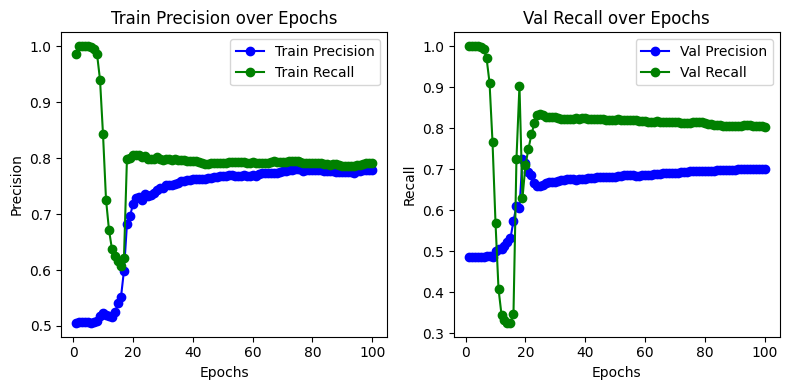

In [19]:
# ----------------------------------------------------------------------------
# 모델 초기화
# ----------------------------------------------------------------------------
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

def build_model():
    # bidlstm 모델 생성
    # model = tf.keras.Sequential([
    #     tf_keras.layers.Input(shape=(X_train.shape[1], )),  # X_train 속성개수
    #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, return_sequences=True), input_shape=input_shape),
    #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=False)),
    #     tf.keras.layers.Dense(units=1, activation='sigmoid')
    # ])

    # lstm 모델 생성
    input = tf_keras.layers.Input(shape=(3, 17))  # shape=(n일치, 컬럼 수)
    x = tf_keras.layers.LSTM(units=512, return_sequences=True)(input)  # return_sequences=True: 각 스텝의 출력을 보존. RNN, LSTM 모두 여러층을 쌓을때 True값으로 해줘야 함
    x = tf_keras.layers.LSTM(units=256, return_sequences=True)(x)
    x = tf_keras.layers.LSTM(units=128, return_sequences=True)(x)
    x = tf_keras.layers.LSTM(units=64, return_sequences=False)(x)  # 최종출력은 1개만 나와야 하므로 return_sequences=False
    output = tf_keras.layers.Dense(units=1, activation='sigmoid')(x)  # RNN에서는 Flatten안해도 됨
    model = tf_keras.models.Model(input, output)

    # # 모델 구성
    # model = tf.keras.Sequential([
    #     tf_keras.layers.Input(shape=(X_train.shape[1], )),  # X_train 속성개수
    #     tf.keras.layers.Dense(512, activation='relu'),
    #     tf.keras.layers.Dense(256, activation='relu'),
    #     tf.keras.layers.Dense(128, activation='relu'),
    #     tf.keras.layers.Dense(64, activation='relu'),
    #     tf.keras.layers.Dense(1, activation='sigmoid')
    # ])

    return model

model = build_model()
model.summary()

# 모델 컴파일
adam_optimizer = tf_keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam_optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# 모델 학습
epochs = 100
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)
# history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val))

# 에폭에 따른 Precision과 Recall 값 추출
train_precision = history.history[[key for key in history.history.keys() if key.startswith('precision')][0]]
train_recall = history.history[[key for key in history.history.keys() if key.startswith('recall')][0]]
val_precision = history.history[[key for key in history.history.keys() if key.startswith('val_precision')][0]]
val_recall = history.history[[key for key in history.history.keys() if key.startswith('val_recall')][0]]

# 그래프 그리기
plt.figure(figsize=(8, 4))

epochs_range = range(1, epochs + 1)

# Train Precision 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_precision, label='Train Precision', marker='o', color='blue')
plt.plot(epochs_range, train_recall, label='Train Recall', marker='o', color='green')
plt.title('Train Precision over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Val Recall 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_precision, label='Val Precision', marker='o', color='blue')
plt.plot(epochs_range, val_recall, label='Val Recall', marker='o', color='green')
plt.title('Val Recall over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# ----------------------------------------------------------------------------
# Test 데이터 평가
# ----------------------------------------------------------------------------
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score

last_X_train = np.concatenate((X_train, X_val), axis=0)
last_y_train = np.concatenate((y_train, y_val), axis=0)

# 모델 초기화
model = build_model()

# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

# 모델 학습
epochs = 50  # 최적 에폭 수
model.fit(last_X_train, last_y_train, epochs=epochs)
print()

# 모델을 사용하여 예측 수행
y_true = np.array(y_test)
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

# 오차 행렬 생성
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])

print("Confusion Matrix:")
print(cm)
print()

print('Test 모델 평가')
# 클래스 1에 대한 정밀도, 재현율, F1 점수 계산
precision_1 = precision_score(y_true, y_pred, pos_label=1)
recall_1 = recall_score(y_true, y_pred, pos_label=1)
f1_1 = f1_score(y_true, y_pred, pos_label=1)

print("Precision (정밀도) for class 1:", precision_1)
print("Recall (재현율) for class 1:", recall_1)
print("F1 Score for class 1:", f1_1)
print()

# 클래스 0에 대한 정밀도, 재현율, F1 점수 계산
precision_0 = precision_score(y_true, y_pred, pos_label=0)
recall_0 = recall_score(y_true, y_pred, pos_label=0)
f1_0 = f1_score(y_true, y_pred, pos_label=0)

print("Precision (정밀도) for class 0:", precision_0)
print("Recall (재현율) for class 0:", recall_0)
print("F1 Score for class 0:", f1_0)

Epoch 1/50
115/115 [==============================] - 7s 15ms/step - loss: 0.6931 - accuracy: 0.5101 - precision_1: 0.5104 - recall_1: 0.2180
Epoch 2/50
115/115 [==============================] - 2s 14ms/step - loss: 0.6935 - accuracy: 0.4981 - precision_1: 0.4607 - recall_1: 0.0908
Epoch 3/50
115/115 [==============================] - 2s 14ms/step - loss: 0.6755 - accuracy: 0.5470 - precision_1: 0.5547 - recall_1: 0.4234
Epoch 4/50
115/115 [==============================] - 2s 14ms/step - loss: 0.5730 - accuracy: 0.7114 - precision_1: 0.6897 - recall_1: 0.7565
Epoch 5/50
115/115 [==============================] - 2s 14ms/step - loss: 0.5479 - accuracy: 0.7347 - precision_1: 0.7225 - recall_1: 0.7521
Epoch 6/50
115/115 [==============================] - 2s 14ms/step - loss: 0.5260 - accuracy: 0.7500 - precision_1: 0.7379 - recall_1: 0.7665
Epoch 7/50
115/115 [==============================] - 2s 14ms/step - loss: 0.5256 - accuracy: 0.7492 - precision_1: 0.7400 - recall_1: 0.7593
Epoch 

8/8 [==============================] - 0s 6ms/step


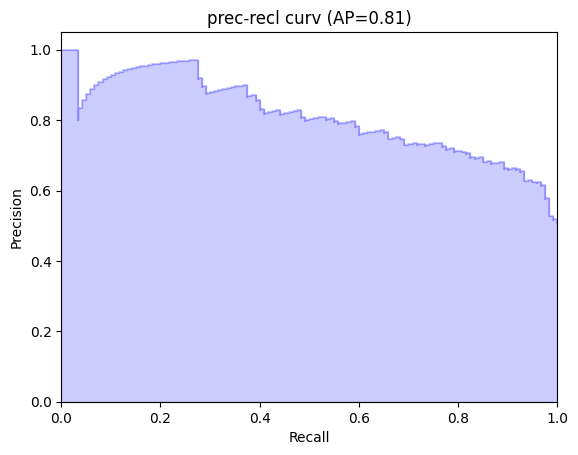

8/8 [==============================] - 0s 5ms/step
임계값: 0.019, 정밀도: 0.5063, 재현율: 1.0000
임계값: 0.019, 정밀도: 0.5085, 재현율: 1.0000
임계값: 0.032, 정밀도: 0.5106, 재현율: 1.0000
임계값: 0.033, 정밀도: 0.5128, 재현율: 1.0000
임계값: 0.034, 정밀도: 0.5150, 재현율: 1.0000
임계값: 0.038, 정밀도: 0.5172, 재현율: 1.0000
임계값: 0.039, 정밀도: 0.5195, 재현율: 1.0000
임계값: 0.048, 정밀도: 0.5174, 재현율: 0.9917
임계값: 0.053, 정밀도: 0.5197, 재현율: 0.9917
임계값: 0.058, 정밀도: 0.5219, 재현율: 0.9917
임계값: 0.060, 정밀도: 0.5242, 재현율: 0.9917
임계값: 0.063, 정밀도: 0.5265, 재현율: 0.9917
임계값: 0.064, 정밀도: 0.5289, 재현율: 0.9917
임계값: 0.065, 정밀도: 0.5268, 재현율: 0.9833
임계값: 0.068, 정밀도: 0.5291, 재현율: 0.9833
임계값: 0.086, 정밀도: 0.5315, 재현율: 0.9833
임계값: 0.088, 정밀도: 0.5339, 재현율: 0.9833
임계값: 0.090, 정밀도: 0.5364, 재현율: 0.9833
임계값: 0.094, 정밀도: 0.5388, 재현율: 0.9833
임계값: 0.097, 정밀도: 0.5413, 재현율: 0.9833
임계값: 0.098, 정밀도: 0.5438, 재현율: 0.9833
임계값: 0.101, 정밀도: 0.5463, 재현율: 0.9833
임계값: 0.105, 정밀도: 0.5488, 재현율: 0.9833
임계값: 0.111, 정밀도: 0.5514, 재현율: 0.9833
임계값: 0.114, 정밀도: 0.5540, 재현율: 0.9833
임계값: 0.118, 정밀도: 0.5566,

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 테스트 세트에 대한 예측을 수행합니다.
y_scores = model.predict(X_test)[:, 0]

# 정밀도-재현율을 계산합니다.
precision, recall, _ = precision_recall_curve(y_test, y_scores)
average_precision = average_precision_score(y_test, y_scores)

# 정밀도-재현율 곡선을 그립니다.
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('prec-recl curv (AP={0:0.2f})'.format(average_precision))
plt.show()

from sklearn.metrics import precision_recall_curve

# 테스트 세트에 대한 예측 확률을 얻습니다.
y_scores = model.predict(X_test)[:]

# 정밀도-재현율 곡선을 그리기 위한 임계값 및 정밀도/재현율을 계산합니다.
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# 임계값을 변경하여 정밀도와 재현율을 출력합니다.
for i, threshold in enumerate(thresholds):
    print("임계값: {:.3f}, 정밀도: {:.4f}, 재현율: {:.4f}".format(threshold, precision[i], recall[i]))

8/8 [==============================] - 0s 6ms/step


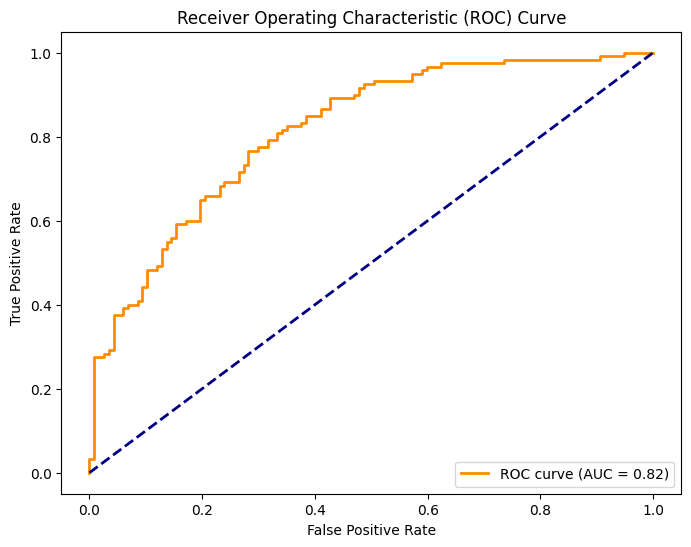

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 예측된 확률과 실제 레이블
y_pred_proba = model.predict(X_test)[:, 0]
y_true = np.array(y_test)

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [23]:
# ----------------------------------------------------------------------------
# backtest 위한 predict_df 생성
# ----------------------------------------------------------------------------
# test 데이터셋의 datetime 추출
selected_col = [col for col in df.columns if col not in ['datetime', 'y']]
X = df['datetime'].astype(str)
y = df['y']

test_datetime = tf_keras.utils.timeseries_dataset_from_array(
    data=X,
    targets=y[days-1:],  # df['y'].shift(-1) 한 경우, y[days-1:]로 해야 맞음
    sequence_length=days,  # 한번에 n일씩
    sampling_rate=stride,  # 1개마다 한 개씩 뽑기
    shuffle=False,
    batch_size=batch_size,
    start_index=test_start,
    end_index=test_end
)

# 데이터셋을 반복하여 X_datetime, y_test 추출
X_datetime, y_test = [], []
for features, labels in test_datetime:
    X_datetime.append(features.numpy())  # 특성 데이터
    y_test.append(labels.numpy())    # 레이블 데이터
X_datetime = np.concatenate(X_datetime, axis=0)
y_test = np.concatenate(y_test, axis=0)

# 추출한 test 데이터셋의 datetime
X_datetime = X_datetime[:, days-1]
X_datetime = [date.decode("utf-8") for date in X_datetime]

# test 데이터셋의 예측값
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)[:, 0]

# predict_df 생성
predict_df = pd.DataFrame()
predict_df['datetime'] = X_datetime
predict_df['predict'] = y_pred
predict_df.to_csv('D:\\doyun\\green-data-analysis2\\teamwork\\project5\\data\\created_csv\\predict_df.csv', index=False)
predict_df

8/8 [==============================] - 0s 5ms/step


,datetime,predict
0,2013-01-04,1
1,2013-01-07,1
2,2013-01-08,1
3,2013-01-09,0
4,2013-01-10,0
...,...,...
232,2013-12-20,0
233,2013-12-23,1
234,2013-12-24,1
235,2013-12-26,1
